# The Poisson distribution, exponential distribution, and Gillespie algorithm

# Import modules
___

In [1]:
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import scipy.stats as sp

plt.style.use('custom.mplstyle')
%config InlineBackend.figure_format = 'retina'

# Set up a random number generator
___

In [2]:
rng = np.random.default_rng(seed=0)

For this assignment, we will also be using `np.random.random` and `np.random.exponential` where indicated. This is because we benefit highly from using the Numba module, which compiles Python code and makes it orders of magnitude faster, and Numba is incompatible with `np.random.default_rng` objects.

# Introduction
____

In [Part 2](https://github.com/StatPhysBio/biophysics/tree/main/part2), we learned how to integrate deterministic differential equations numerically. The nuance there was choosing $\Delta t$ to be smaller than the time scale characterizing whatever model we were interested in. Though solving deterministic equations gives us a sense of what is happening on average, simulating stochastic systems allows us to deepen our intuition and generate synthetic data which can serve as a baseline understanding for real-world phenomena.

One algorithm for doing so is called the Gillespie algorithm. It is a method of producing realizations (statistically correct instances) of a stochastic equation. Rather than using numerical integration and computing something every $\Delta t$, it incorporates knowledge about the model regarding the duration of time between chemical reactions. The algorithm uses this feature to carry out computations only when reactions occur, making it more efficient and tractable.

## Biological motivation

A basic picture of simple mRNA dynamics can be illustrated by writing reaction equations:

\begin{align}
\begin{array}{ll}
\text{reaction, }r_i & \text{rate, } k_i \\
m \rightarrow m+1,\;\;\;\; & k \\[0.3em]
m \rightarrow m-1, \;\;\;\; & \gamma m\\[0.3em]
\end{array}
\end{align}

mRNA is created at rate $k$, and mRNA is degraded at a rate $\gamma$ times the current amount of mRNA. These events are assumed to follow three important properties:
- they are rare
- the number of mRNA increases or decreases discretely by 1
- reactions are independent of one another

To characterize the dynamics of mRNA, we would like to obtain the probability distribution $p(m, t)$. I.e., what is the probability of having $m$ mRNA at time $t$. 

### What are the units of $k$ and $\gamma$?

**your answer:** $[k] = T^{-1}$ and $[\gamma] = \frac{1}{T^{-1} (\mathrm{mRNA}^{-1})}$ where $T$ is some arbitrary unit of time.

## Master equation

We can write the time evolution of $p(m,t)$ using a master equation.

$$
\frac{d p(m,t)}{dt} = -k p(m,t) + k p(m-1, t) - \gamma m p(m, t) + \gamma (m+1) p(m+1, t)
$$

### Describe what each of these four terms represents.

**your answer:** The first term represents the decrease of $p(m,t)$ due to $m$ transitioning to $m + 1$ at rate $k$. The second term represents a gain in $p(m,t)$ from $m-1$ transitioning to $m$ which occurs at rate $k$. The third term describes the loss of $p(m,t)$ from $m$ transitioning to $m-1$ at rate $\gamma m$. The final term describes in the increase in $p(m,t)$ from $m+1$ transitioning to $m$ at rate $\gamma (m+1)$.

The evolution of the mean can be found to be

$$
\frac{d \langle m(t) \rangle}{dt} = \sum_{m=0}^{\infty}m \frac{d p(m,t)}{dt} = k - \gamma \langle m(t) \rangle
$$

### Solve this equation and obtain $\langle m(t) \rangle$.

**your answer:** 
$$
\langle m(t) \rangle = \frac{k}{\gamma} \left(1 - e^{-\gamma t}\right)
$$

### What is the steady-state $\langle m(t) \rangle$?

Hint: let $t \to \infty$.

**your answer:** $k / \gamma$

# Relevant statistical distributions
___

## Poisson distribution

The Poisson distribution is used to model discrete, rare events and is the expected stationary distribution for the number of mRNA given the simple dynamics above. Recall the binomial process from [Part 3](https://github.com/StatPhysBio/biophysics/tree/main/part3). As a reminder, a binomial process can be thought of as flipping a coin $N$ times where the probability of seeing a heads is $p$. Then the probability of observing $n$ heads out of $N$ coin flips is

$$
P(n|p,N) = {N \choose n} p^n (1-p)^{N-n}
$$

Let's imagine that observing a heads is rare, and the average number of heads observed is fixed. I.e., $p \to 0$, $N \to \infty$, and $Np = \lambda$ is fixed. When we take $p$ and $N$ to their limits, the binomial distribution can be manipulated into a more illuminating form. We begin by rewriting $p$ as $\lambda / N$ to focus on taking the limit of one variable.

$$
\begin{align*}
\lim_{N \to \infty, \, p \to 0} P(n|p,N) &= {N \choose n} p^n (1-p)^{N-n} \\
\lim_{N \to \infty} P(n|\lambda, N) &= {N \choose n} \left( \frac{\lambda}{N} \right)^n \left(1 - \frac{\lambda}{N} \right)^{N-n}
\end{align*}
$$

Observing a heads is rare and $N \to \infty$. Therefore, $N \gg n$, and $N - n = N$ as $N \to \infty$. Additionally, $N \to \infty$ permits us to use $1 - \lambda / N = e^{-\lambda / N}$.

$$
\begin{align*}
\lim_{N \to \infty} P(n|\lambda,N) &= {N \choose n} \left( \frac{\lambda}{N} \right)^n \left(e^{-\lambda / N} \right)^{N} \\
&= {N \choose n} \left( \frac{\lambda}{N} \right)^n e^{-\lambda}
\end{align*}
$$

Next, we expand ${N \choose n}$.

$$
\begin{align*}
\lim_{N \to \infty} P(n|\lambda,N) &= \frac{N!}{n!(N-n)!} \left( \frac{\lambda}{N} \right)^n e^{-\lambda} \\
&= \frac{(N)(N-1)(N-2)(N-3)\ldots(N-n+1)}{N!} \left( \frac{\lambda}{N} \right)^n e^{-\lambda}
\end{align*}
$$

where we divided $N!$ by $(N-n)!$. Again, because $N \gg n$, $N - n = N$ as $N \to \infty$. Then, $(N)(N-1)(N-2) \ldots (N-n+1) = N^n$.

$$
\begin{align*}
\lim_{N \to \infty} P(n|\lambda,N) &= \frac{N^n}{n!} \frac{\lambda^n}{N^n} e^{-\lambda} \\
&= \frac{\lambda^n}{n!} e^{-\lambda}
\end{align*}
$$

Thus the dependence on $N$ goes away, and $\lambda$ is the only parameter. The Poisson distribution is thus a one-parameter distribution and has the form

$$
P(n | \lambda) = \frac{\lambda^n}{n!} e^{-\lambda}
$$

Intuitively, the Poisson distribution characterizes the number of events $n$ occuring in a fixed time window, and the single parameter of the distribution $\lambda$ corresponds to the average number of events in this window. 

### The code for simulating binomial random numbers is recreated from Part 3 below.

In [3]:
def my_binomial(rng, p, num_trials, num_experiments):
    """
    Generate binomial random variables from uniform random numbers.
    
    Parameters
    ----------
    rng : numpy.random.Generator
        Random number generator.
    p : float
        The probability of seeing a heads.
    num_trials : int
        The amount of coin flips in a single binomial experiment.
    num_experiments : int
        The number of experiments simulated.
        
    Returns
    -------
    outcome_counts : numpy.ndarray
        A one-dimesional array of integers describing how many heads were observed
        in each binomial experiment.
    distribution : numpy.ndarray
        The outcomes binned.
    """
    rands = rng.random(size=(num_experiments, num_trials))
    outcomes = rands <= p
    outcome_counts = np.sum(outcomes, axis=1)
    distribution = np.bincount(outcome_counts) / outcome_counts.shape[0] 
    return outcome_counts, distribution

### Let $\lambda = 5$. Take the pairs of $(p, N) \in \{(0.5, 10), (0.05, 100), (0.005, 1000), (0.0005, 10000)\}$ and simulate 10,000 binomial experiments. Histogram the outcomes from the simulations, and plot the Poisson distribution using `sp.poisson.pmf`. The mean and variance of an Poisson distribution are both $\lambda$. Annotate the empirical values of the mean and variance onto each plot.

`sp.poisson.pmf` takes two arguments. The first is an array of integers corresponding to `n` ($n$). The second is `lam` ($\lambda$, the average $n$ you expect to see). Hence, call it using `sp.poisson.pmf(n, lam)`.

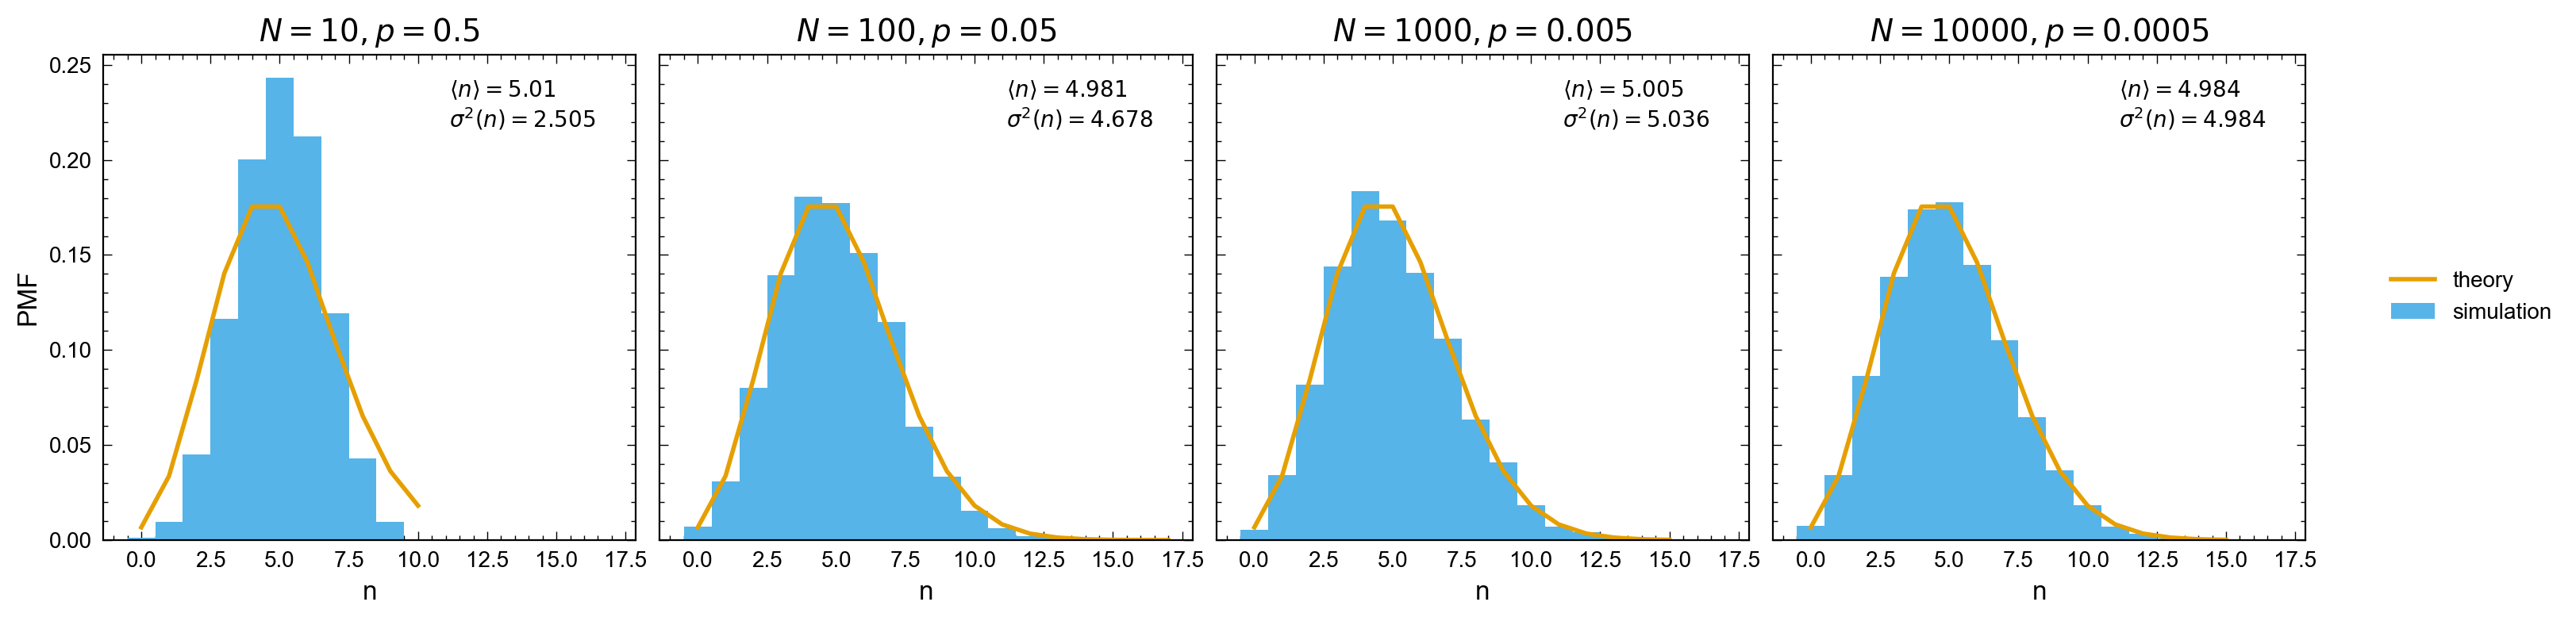

In [4]:
lam = 5
Ns = 10**np.arange(1, 5, 1)
num_experiments = 10000

fig, axes = plt.subplots(ncols=4, figsize=(16,4), sharey=True, sharex=True)

distributions = []
for N, ax in zip(Ns, np.ravel(axes)):
    p = lam / N
    outcomes, _ = my_binomial(rng, p, N, num_experiments)
    
    bins = np.arange(np.min(outcomes), np.max(outcomes) + 1)
    centered_bins = bins - 0.5
    
    ax.hist(outcomes, bins=centered_bins, density=True, label='simulation')
    ax.plot(bins, sp.poisson.pmf(bins, lam), label='theory', linewidth=2)
    text = ('$\\langle n \\rangle = ' + str(np.round(np.mean(outcomes), 3)) +'$\n'
            + '$\sigma^2(n) = ' + str(np.round(np.var(outcomes), 3)) +'$')
    ax.annotate(text, xy=(0.65, 0.85), color='black', xycoords='axes fraction')
    ax.set_title('$N=' + str(N) + ', p=' + str(p) + '$')
    ax.set_xlabel('n')
    
axes[0].set_ylabel('PMF')
axes[-1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

fig.tight_layout()
plt.show()

### Given the visualization, mean, and variance, what is the $p$, $N$ pair with the largest $p$ and smallest $N$ for which a binomial distribution converges roughly to a Poisson distribution?

**your answer:** We see that $N=1000$, $p=0.005$ achieves a good fit visually in addition to there being a good agreement for $\langle n \rangle = \sigma^2(n)$. This demonstrates that even though mathematically $N \to \infty$, $p \to 0$ for obtaining the Poisson distribution from the binomial, practically, $N$ and $p$ don't have to be so large and small, respectively. **The takeaway: $N$ and $p$ need not be at the extremes of their limits (things don't need to be _incredibly_ rare) for the Poisson distribution to characterize something successfully.**

## Continuous-time Poisson distribution

We can also imagine $\lambda$ as not being the average over trials but time. When we count how many times some rare phenomena occurs over a very large number of trials, it can be more convenient to measure time continuously. The number of trials $N$ per experiment is a discrete value. We can imagine some time $t$ which is broken into $N$ different intervals of size $\Delta t$: $t / N = \Delta t$. As $N \to \infty$, $\Delta t \to dt$. We can write $\lambda = k t$, where $k$ is the rate at which some rare phenomena occurs per unit time. Then the Poisson distribution takes the form:

$$
P(n|k, t) = \frac{(k t)^n}{n!} e^{-k t}
$$

### Does $k=2$, $t=5$ produce the same Poisson distribution as $k=2$, $t=7$? 

**your answer:** $t$ is a parameter of the Poisson distribution. Therefore using a different $t$ will result in a different Poisson distribution.

## Exponential distribution

What is the probability a single Poisson event occurs within an interval of time $[0,t]$? We answer this by asking the inverse: what is the probability that the time at which a Poisson event occurs $T$ is beyond our interval of observation $[0,t]$? This second question is a reframing of the question: what is the probability no Poisson event occurs within an interval of time $[0, t]$?

$$
P(T > t|k) = P(n=0 | k, t) = e^{-kt}
$$

Then the probability of observing a Poisson event within a time interval of $[0,t]$ is

$$
P(T \leq t|k) = 1 - e^{-kt}
$$

(This is also the probability of observing at least one Poisson event in $[0,t]$. If at least one Poisson event has occurred in $[0,t]$, then of course a Poisson event will be observed in $[0,t]$.) This distribution is called the exponential distribution, and it models the duration of time between Poisson events. What we have calculated, $P(T \leq t|k)$, is called the cumulative distribution function of the exponential distribution: it is the sum of all the probabilities of observing a Poisson event at any time in $[0,t]$. The probability density function is obtained by taking the derivative of $P(T \leq t)$ with respect to $t$:

$$
\frac{dP(T \leq t|k)}{dt} = P(T = t|k) = k e^{-kt}
$$

As a reminder, a probability density becomes a probability when we multiply it by the appropriate measure. Explicitly, the probability that a Poisson event occurs at $T = t$ is

$$
P(T = t|k)dt = k e^{-kt} dt
$$

*Note: exponential distributions can be parameterized by the rate $k$ or the characteristic time $1/k$. Mathematically, we parameterize it by $k$. In NumPy and SciPy, it is parameterized by $1/k$.*

### Write a function which computes how many tails were observed in an experiment before the first heads. Convert the number of tails observed into a continuous measure of time by specifying how many trials are performed in a single unit of time.

It should have as its parameters:
- `rng`, a numpy random number generator object
- `p`, the probability of seeing a heads
- `total_trials`, the maximum number of trials to test to see if an experiment yields a heads
- `num_experiments`, the number of experiments to conduct
- `trials_per_time`, the number of trials per unit time (this can be a float unlike `total_trials` which must be an int)

It should return:
- `durations`, a one-dimensional numpy array containing the durations of time before the first heads was observed in the experiments

**If a heads is never observed in an experiment, that experiment should be ignored. Not doing so will distort the distribution artificially.** Further, `total_trials` is an integer used to tune how long the experiments should run. It **needs** to be chosen big enough such that we observe the entire domain of the distribution. If `total_trials` is too small, the resulting output will not match the analytic distribution because we will have prohibited ourselves from simulating all the potential durations.

In [5]:
def my_exponential(rng, p, total_trials, num_experiments, trials_per_time):
    rands = rng.random(size=(num_experiments, total_trials))
    outcomes = rands <= p
    outcome_counts = np.sum(outcomes, axis=1)
    
    """
    Use a boolean numpy array to keep only the rows in the outcomes matrix in which
    a heads was observed. Hint: what value is in counts if no heads are observed?
    """
    experiments_w_heads = outcomes[outcome_counts != 0]
    
    """
    Find the amount of failures that occurred before the first heads is seen.
    Use np.argmax and axis=1 https://numpy.org/doc/stable/reference/generated/numpy.argmax.html
    np.argmax will return the index of the column at which the first heads
    are seen for each row(when using axis=1). Because Python's indices begin at 0,
    how does that impact computing the amount of failures before the first heads?
    In other words, if I have np.array([False, False, False, True]), what will np.argmax
    return and how does this compare with how many False are in this array?
    """
    durations = np.argmax(experiments_w_heads, axis=1)
    
    durations = durations.astype(np.float64)
    
    """
    Divide the durations by trials_per_time.
    """
    durations /= trials_per_time
    return durations

### Let $k = 5$. Take the pairs of $(p, N) \in \{(0.5, 10), (0.05, 100), (0.005, 1000), (0.0005, 10000)\}$, where $N$ is `trials_per_time`, and simulate the time until a heads is observed. Set `total_trials` $= 25000$ and `num_experiments` $= 10000$ . For each pair, plot a histogram of the durations, and plot the expected exponential distribution using `sp.expon.pdf`. The mean and variance of an exponential distribution are $1/k$ and $1/k^2$, respectively. Annotate these values onto each plot.

Observe `k = p * trials_per_time`. To use `sp.expon.pdf`, type `sp.expon.pdf(x, scale=1/k)` where `x` is a numpy array of floats. If you do not use the `scale` keyword, this will not work as expected.

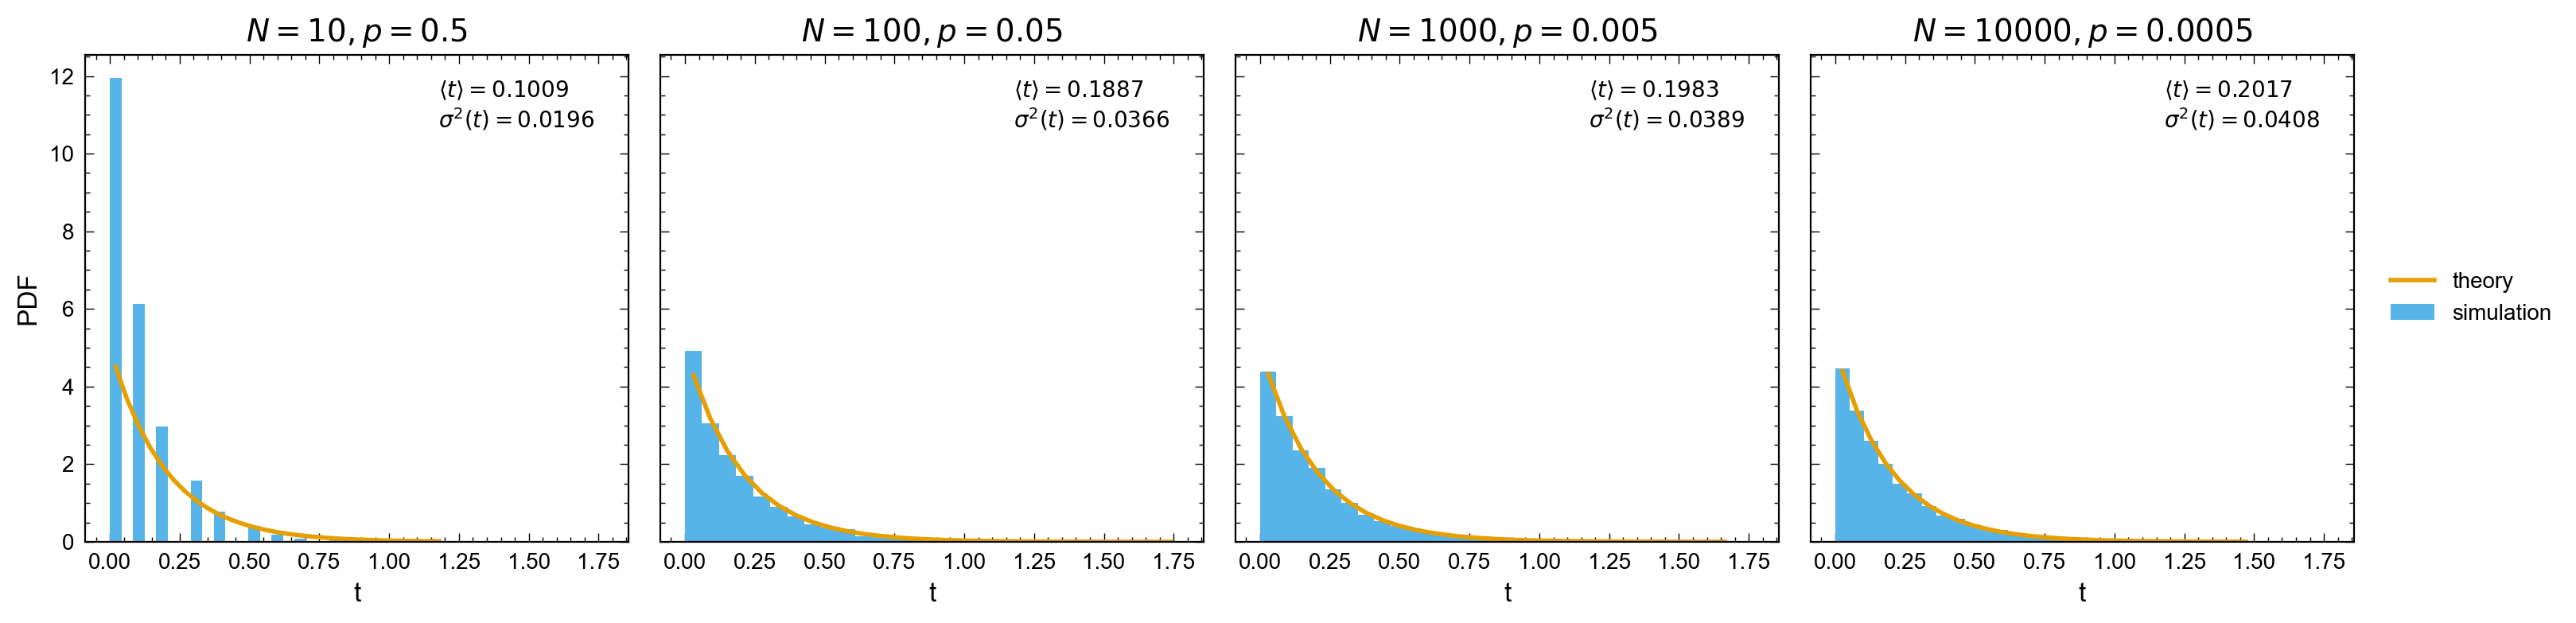

In [6]:
k = 5
Ns = 10**np.arange(1, 5, 1)
total_trials = 25000
num_experiments = 10000

fig, axes = plt.subplots(ncols=4, figsize=(16, 4), sharey=True, sharex=True)

for N, ax in zip(Ns, np.ravel(axes)):
    p = k / N
    durations = my_exponential(rng, p, total_trials, num_experiments, N)
    
    x = np.linspace(0, np.max(durations), 30)
    bin_centers = (x[:-1] + x[1:]) / 2

    ax.hist(durations, bins=x, density=True, label='simulation')
    ax.plot(bin_centers, sp.expon.pdf(bin_centers, scale=1/k), linewidth=2, label='theory')
    text = ('$\\langle t \\rangle = ' + str(np.round(np.mean(durations), 4)) + '$\n'
            + '$\sigma^2(t) = ' + str(np.round(np.var(durations), 4)) + '$')
    ax.annotate(text, xy=(0.65, 0.85), color='black', xycoords='axes fraction')
    ax.set_xlabel('t')
    ax.set_title('$N=' + str(N) + ', p=' + str(p) + '$')

axes[0].set_ylabel('PDF')
axes[-1].legend(loc='center right', bbox_to_anchor=(1.4, 0.5))

fig.tight_layout()
plt.show()

### Given the visualization, mean, and variance, what is the $p$, $N$ pair with the largest $p$ and smallest $N$ for which the distribution of the simulated data converges roughly to a exponential distribution?

**your answer:** Again, $N = 1000$, $p = 0.005$ demonstrates a good agreement between the simulation and theory visually and for $\langle t \rangle^2 = \sigma^2(t)$. This is in line with what we stated above for the Poisson distribution.

## Exponential distribution properties

Let there be two populations $A$ and $B$. $A$ can transform into $B$ at rate $k_1$. $B$ can transform in $A$ at rate $k_2$. Assume these two processes are Poisson and independent of one another.

$$
A \underset{k_2}{\stackrel{k_1}{\rightleftharpoons}} B
$$

The amount of time before $A$ transforms into $B$ is exponentially distributed with rate $k_1$. Likewise, the amount of time before $B$ transforms into $A$ is exponentially distributed with rate $k_2$. Let $T_1$ be the time at which $A$ transforms into $B$ and $T_2$ be the time at which $B$ transforms into $A$. Then

$$
\begin{align*}
P(T_1 \leq t) &= 1 - e^{-k_1 t} \\
P(T_2 \leq t) &= 1 - e^{-k_2 t}
\end{align*}
$$

We'd like to know the time it takes before the first event happens, i.e., either when $A \to B$ or when $B \to A$. Mathematically, we are interested in $T = \min(T_1, T_2)$.

$$
\begin{align*}
P(T \leq t) &= 1 - P(T > t) \\
&= 1 - P(\min(T_1, T_2) > t)
\end{align*}
$$

$\min(T_1, T_2) > t$ if and only if both $T_1 > t$ and $T_2 > t$. Since $T_1$ and $T_2$ are independent

$$
\begin{align*}
P(T \leq t) &= 1 - P(\min(T_1, T_2) > t) \\
&= 1 - P(T_1 > t) P(T_2 > t) \\
&= 1 - e^{-k_1 t} e^{-k_2 t} \\
&= 1 - e^{-(k_1 + k_2) t}
\end{align*}
$$

Thus the duration of time before either event occurs is also exponentially distributed with rate $k_1 + k_2$. Now given an event occurs, what is the probability that $A \to B$ happens first: what is $P(T_1 < T_2)$? We figure this out by computing the probability of $T_1$ being a certain time $t$, multiplying by the probability that $T_2 > t$, and by integrating over all the possible values of $t$.

$$
\begin{align*}
P(T_1 < T_2) &= \int_0^\infty P(T_1 = t) P(T_2 > t) dt \\
&= \int_0^\infty \left( k_1 e^{-k_1 t} \right) \left(e^{-k_2 t} \right) dt \\
&= k_1 \int_0^\infty e^{-(k_1 + k_2) t} dt \\
&= \frac{k_1}{k_1 + k_2}
\end{align*}
$$

Thus, given that an event occurs, the probability that $A \to B$ is merely the ratio of $k_1$ to the sum of the rates. Both of these proofs extend easily to more than two reactions. The time until the first reaction is exponentially distributed with rate $\sum_j k_j$, and the probability the $i$th transformation occurs is $k_i / \sum_j k_j$.

These two features are fundamental to the Gillespie algorithm.

### Conduct two Poisson coin-flipping experiments. Let one coin (coin 1) have $p=0.003$ and another coin (coin 2) have $p=0.005$. Flip coin 1 slower than coin 2 for each experiment (imagine our unit of time is an hour): set `trials_per_time` $=100$ for coin 1 and `trials_per_time` $=200$ for coin 2. Set `total_trials` $= 5000$, `num_experiments` $= 10000$. Compute the probability that flipping coin 1 results in a heads before coin 2. Compare this to the expected value.

`total_trials` has been chosen such that all 10,000 experiments will see a heads at some point for each coin with the probabilities above. If the probabilities of seeing a heads are made smaller, make sure you change `total_trials` accordingly!

In [7]:
p1 = 0.003
p2 = 0.005
total_trials = 5000
num_experiments = 10000
trials_per_time1 = 100
trials_per_time2 = 200
k1 = trials_per_time1 * p1
k2 = trials_per_time2 * p2

durations1 = my_exponential(rng, p1, total_trials, num_experiments, trials_per_time1)
durations2 = my_exponential(rng, p2, total_trials, num_experiments, trials_per_time2)

"""
Obtain the probability that flipping coin 1 results in a heads before coin 2.
Use a boolean numpy array, np.sum, and num_experiments.
"""
prob_coin1_first = np.sum(durations1 < durations2) / num_experiments

print('simulated value:', prob_coin1_first)
print('expected value:', k1 / (k1 + k2))

simulated value: 0.2326
expected value: 0.23076923076923075


# Gillespie algorithm
___

### Write a function that implements the Gillespie algorithm.

It should have as its parameters:
- `k`, the mRNA transcription rate
- `gamma`, the decay rate
- `T`, the time at which the simulations should end
- `mrna_count`, the initial number of mRNA molecules

It should return:
- `times`, a one-dimensional numpy array containing the times at which events have occurred
- `mrna_counts`, a one-dimensional numpy array containing the mRNA counts over the course of the simulation

*Note: do not erase `@nb.njit`. It is what tells `numba` to compile our `gillespie` function, making it fast!*

In [11]:
@nb.njit
def gillespie(k, gamma, T, mrna_count=0):
    # We don't use numpy arrays to store the times and mRNA counts
    # because we don't know how many events will occur.
    times = [0]
    mrna_counts = [mrna_count]
    
    time_elapsed = 0
    
    while time_elapsed <= T:
        """
        Compute the degredation rate.
        """
        degredation_rate = gamma * mrna_counts[-1]
        
        """
        Save the total sum of the rates to a variable called sum_rates.
        """
        sum_rates = k + degredation_rate

        """
        Use sum_rates and np.random.exponential to generate the time to the next event.
        Recall that np.random.exponential takes 1 / rate as its parameter.
        """
        interarrival_time = np.random.exponential(1 / sum_rates)

        """
        Add the above generated time to the time_elapsed.
        """
        time_elapsed += interarrival_time
        
        """
        Draw a random number using np.random.random().
        Use an if-else statement to determine whether the mRNA count increases
        or decreases by 1 by using the event probabilities.
        """        
        if np.random.random() <= k / sum_rates:
            mrna_count += 1
        else:
            mrna_count -= 1
        
        times.append(time_elapsed)
        mrna_counts.append(mrna_count)
        
    return np.array(times), np.array(mrna_counts)

### Set $k = 20 \, \mathrm{min}^{-1}$, $\gamma = 0.67 \, \mathrm{min}^{-1}$, $T=10 \, \mathrm{min}$, and $m(0) = 0$. Plot 10 trajectories. Also plot your solution for $\langle m(t) \rangle$ as a black dashed line.

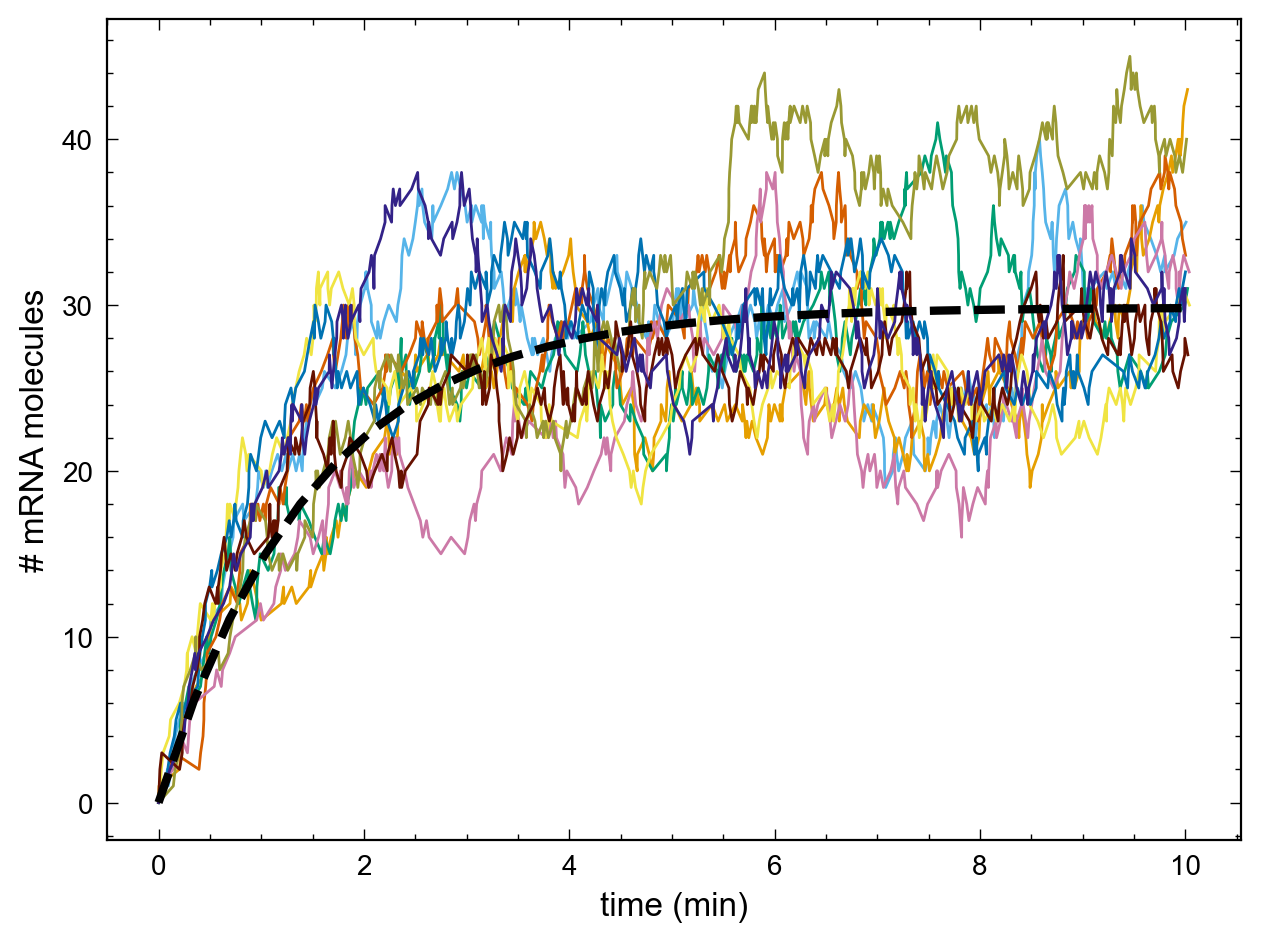

In [13]:
fig, ax = plt.subplots()
k = 20
gamma = 0.67
T = 10
"""
Use a for loop and run your simulation accordingly.
"""
for i in range(10):
    t, m = gillespie(k, gamma, T)
    ax.plot(t, m)

"""
Plot <m(t)>. Use 30 evenly spaced bins in [0, 10].
"""
times = np.linspace(0, 10, 30)
mean_m = (1 - np.exp(-gamma * times)) * k / gamma

ax.plot(times, mean_m,
        color='black', linestyle='--', linewidth=3)
    
ax.set_xlabel('time (min)')
ax.set_ylabel('# mRNA molecules')

fig.tight_layout()
plt.show()

### Run your simulation for 10,000 times using the same parameters as above, and make a histogram of the steady-state mRNA distribution. The steady-state distribution is Poisson. Plot a Poisson distribution with the theoretical steady-state mean as its parameter. Annotate the mean and variance.

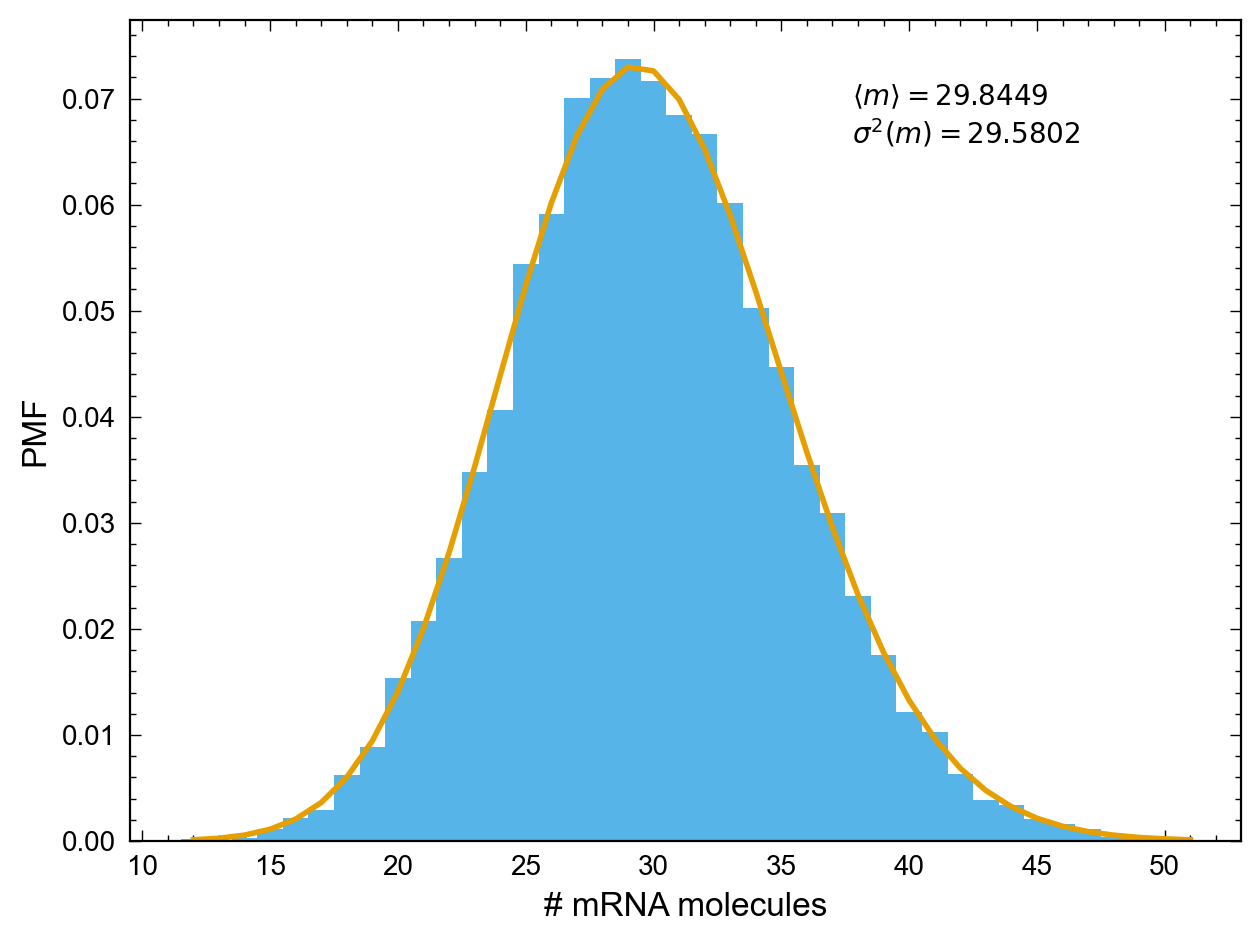

In [10]:
steady_state_m = np.zeros(shape=10000)

"""
Use a for loop and run your simulation for 10,000 times, storing the final mRNA count in steady_state_m.
"""
for idx in range(steady_state_m.shape[0]):
    t, m = gillespie(k, gamma, T)
    steady_state_m[idx] = m[-1]

fig, ax = plt.subplots()

x = np.arange(np.min(steady_state_m), np.max(steady_state_m) + 1)
centered_bins = x - 0.5
ax.hist(steady_state_m, bins=centered_bins, density=True)

"""
Set the theoretical steady-state mean.
"""
theoretical_steady_state_mean = k / gamma

ax.plot(x, sp.poisson.pmf(x, theoretical_steady_state_mean), linewidth=2)
text = ('$\\langle m \\rangle = ' + str(np.round(np.mean(steady_state_m), 4)) + '$\n'
        + '$\sigma^2(m) = ' + str(np.round(np.var(steady_state_m), 4)) + '$')
ax.annotate(text, xy=(0.65, 0.85), color='black', xycoords='axes fraction')
ax.set_xlabel('# mRNA molecules')
ax.set_ylabel('PMF')

fig.tight_layout()
plt.show()